In [2]:
# https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
import math
import copy
import random
from dataclasses import dataclass

In [4]:
from algo.dynamicProgramming import dynamicPlayer
from algo.iplayer import RandomPlayer, IPlayer
from algo.q_learning import QLearning
from algo.board import Board, GameState

In [5]:
device = torch.device(
    # "cuda" if torch.cuda.is_available() else
    # "mps" if torch.backends.mps.is_available() else
    "cpu"
)
device

device(type='cpu')

In [9]:
class DQN(nn.Module):
	"""
	Using structure similar to NNUE:
	https://www.chessprogramming.org/File:StockfishNNUELayers.png
	
	Observation space: hot-encoded board:
	for each of 18 cells we can be -2, -1, 0, 1, 2 (5 possibilities).
	In total it gives 18 * 5 = 90 possible inputs, out of which at most 12 are on.
	
	# Action space: 4 possible actions.
	Value function: 1 output. # https://www.reddit.com/r/reinforcementlearning/comments/1b1te73/help_me_understand_why_use_a_policy_net_instead/
	"""

	def __init__(self):
		super(DQN, self).__init__()

		layer_sizes = [
			90,
			50,
			50,
			1
		]

		layers = []
		prev_size = layer_sizes[0]
		for cur_size in layer_sizes[1:]:
			layers.append(nn.Linear(prev_size, cur_size))
			prev_size = cur_size

		self.layers = nn.ModuleList(layers)

	def forward(self, board: Board, flipped = False) -> torch.Tensor:
		state = board.to_tensor(device, flipped)
		for layer in self.layers[:-1]:
			state = F.relu(layer(state))
		return self.layers[-1](state)

In [7]:
def make_environment_step(state: Board, action: tuple[tuple[int, int], tuple[int, int]], enemy: IPlayer, current_step: int) -> tuple[Board, torch.Tensor]:
	"""
	Returns new state and reward for the given action.
	"""
	state = copy.deepcopy(state)
	cur_sign = state.turn_sign
	we_captured = state.make_move(*action) * cur_sign
	enemy_captured = 0
	while state.game_state == GameState.NOT_OVER and state.turn_sign != cur_sign:
		enemy_captured += state.make_move(*enemy.decide_move(state)) * cur_sign * (-1)

	reward = we_captured - enemy_captured
	if current_step > 10 and not we_captured:
		reward -= 2
		
	if state.game_state != GameState.NOT_OVER:
		our_pieces = 0
		enemy_pieces = 0
		for _, piece in state:
			if piece == cur_sign:
				our_pieces += 1
			elif piece == -cur_sign:
				enemy_pieces += 1
			elif piece == 2 * cur_sign:
				our_pieces += 2
			elif piece == -2 * cur_sign:
				enemy_pieces += 2
			
		reward += 3 * our_pieces / (enemy_pieces + 1)

		if state.game_state == GameState.DRAW:
			reward -= 40
		elif state.game_state == GameState(cur_sign):
			reward += 40
		elif state.game_state == GameState(-cur_sign):
			reward -= 40
		else:
			raise ValueError("Unexpected game state")
	
	return state, torch.Tensor([reward])

In [ ]:
from typing import Iterator

def move_iterator(state: Board) -> Iterator[tuple[tuple[int, int], tuple[int, int]]]:
	for s in state.get_possible_pos():
		for e in state.get_possible_pos():
			yield (s, e)

In [7]:
GAMMA = 0.99 # discount rate

@dataclass
class Action:
	action: tuple[tuple[int, int], tuple[int, int]]
	value: torch.Tensor

def q_s(dqn: DQN, current_state: Board, our_sign: int, flipped = False) -> Action:
	"""
	Return: list[(new_state, action, immediate_reward, value)]
	"""
	ret: list[Action] = []
	for s in current_state.get_possible_pos():
		for e in current_state.get_correct_moves(s):
			next_state = copy.deepcopy(current_state)
			immediate_reward = torch.tensor([next_state.make_move(s, e) * our_sign], device=device)
			value = dqn(next_state, flipped) * GAMMA + immediate_reward
			ret.append(Action((s, e), value))
	
	return max(ret, key=lambda x: x.value)

In [ ]:
def td2(dqn: DQN, current_state: Board) -> Action:
	cur_sign = current_state.turn_sign
	ret: list[Action] = []
	for my_move in move_iterator(current_state):
		next_state = copy.deepcopy(current_state)
		value = torch.tensor([next_state.make_move(*my_move) * next_state.turn_sign], device=device)

		step = 1
		while next_state.game_state == GameState.NOT_OVER and next_state.turn_sign == cur_sign:
			value += next_state.make_move(*q_s(dqn, next_state, cur_sign).action) * cur_sign * GAMMA ** step
			step += 1
		
		while next_state.game_state == GameState.NOT_OVER and next_state.turn_sign != cur_sign:
			s, e = q_s(dqn, next_state, -cur_sign, True).action
			value -= next_state.make_move((s[1], s[0]), (e[1], e[0])) * cur_sign * GAMMA ** step
			step += 1
		
		

In [8]:
BATCH_SIZE = 128 # number of transitions sampled from the replay buffer

EPS_START = 0.05 # exploration rate
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005 # update rate
LR = 1e-4 # AdamW learning rate

policy_net = DQN().to(device) # to be updated often
target_net = DQN().to(device) # to be updated with TAU
policy_net.load_state_dict(torch.load("dqn80.pth"))
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
steps_done = 0


def select_action(board: Board) -> Action:
	global steps_done
	sample = random.random()
	eps_threshold = EPS_END + (EPS_START - EPS_END) * \
		math.exp(-1. * steps_done / EPS_DECAY)
	steps_done += 1
	if sample > eps_threshold:
		with torch.no_grad():
			state_values = q_s(policy_net, board)
			return max(state_values, key=lambda x: x.value.item())
					
	else:
		possible_moves = []
		for s in board.get_possible_pos():
			for e in board.get_correct_moves(s):
				possible_moves.append((s, e))
		return Action(
			random.choice(possible_moves),
			torch.tensor([0], device=device)
		)

C:\Users\mario\AppData\Local\Temp\ipykernel_304692\634578881.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy_net.load_state_dict(torch.load("dqn80.pth"))


In [9]:
@dataclass
class TransitionRecord:
	current_state: Board
	next_state: Board
	immediate_reward: torch.Tensor

def optimize_model(memory: list[TransitionRecord]):
	if len(memory) < BATCH_SIZE:
		return
	
	state_action_values = []
	expected_state_action_values = []

	for r in random.sample(memory, BATCH_SIZE):
		# Compute Q(s_t, a) - the model computes Q(s_t), then we select the
		# columns of actions taken. These are the actions which would've been taken
		# for each batch state according to policy_net
		state_action_values.append(max(q_s(policy_net, r.current_state), key=lambda x: x.value.item()).value)

		# Compute V(s_{t+1}) for all next states.
		# Expected values of actions for non_final_next_states are computed based
		# on the "older" target_net; selecting their best reward with max(1).values
		# This is merged based on the mask, such that we'll have either the expected
		# state value or 0 in case the state was final.
		next_state_value = 0
		if r.next_state.game_state == GameState.NOT_OVER:
			with torch.no_grad():
				next_state_value = max(q_s(target_net, r.next_state), key=lambda x: x.value.item()).value
		# Compute the expected Q values
		expected_state_action_values.append((next_state_value * GAMMA) + r.immediate_reward)

	# Compute Huber loss
	criterion = nn.SmoothL1Loss()
	loss = criterion(
		torch.cat(state_action_values),
		torch.cat(expected_state_action_values)
	)

	# Optimize the model
	optimizer.zero_grad()
	loss.backward()
	# In-place gradient clipping
	torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
	optimizer.step()

In [10]:
def run_game(net: DQN) -> int:
	enemy = RandomPlayer(random.randint(0, 10000))
	board = Board()
	while board.game_state == GameState.NOT_OVER:
		while board.game_state == GameState.NOT_OVER and board.turn_sign == 1:
			board.make_move(*enemy.decide_move(board))
		while board.game_state == GameState.NOT_OVER and board.turn_sign == -1:
			with torch.no_grad():
				state_values = max(q_s(net, board), key=lambda x: x.value.item())
				board.make_move(*state_values.action)
	
	pieces = 0
	for _, piece in board:
		pieces += piece != 0

	return (1 if board.game_state == GameState(-1) else -1) * pieces

In [ ]:
max_score = 0
backup = None

In [ ]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
	num_episodes = 600
else:
	num_episodes = 50
	
our_sign = -1
memory: list[TransitionRecord] = []

win_rate = []
number_of_steps = []

# enemy = RandomPlayer(random.randint(0, 1000))
q_enemy = QLearning("dqn80.pth")
random_enemy = RandomPlayer(random.randint(0, 1000))

for i_episode in range(num_episodes):
	for enemy in [random_enemy]:
		cur_state = Board()
		cur_state.make_move(*enemy.decide_move(cur_state))
		num_steps = 0
		while True:
			num_steps += 1
			action = select_action(cur_state)
			new_state, immediate_reward = make_environment_step(cur_state, action.action, enemy, num_steps)

			memory.append(TransitionRecord(cur_state, new_state, torch.tensor([immediate_reward], device=device)))
			cur_state = new_state

			if cur_state.game_state != GameState.NOT_OVER:
				win_rate.append(cur_state.game_state == GameState(our_sign))
				break

		# Perform one step of the optimization (on the policy network)
		optimize_model(memory)
		# Soft update of the target network's weights
		# θ′ ← τ θ + (1 −τ )θ′
		target_net_state_dict = target_net.state_dict()
		policy_net_state_dict = policy_net.state_dict()
		for key in policy_net_state_dict:
			target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
		target_net.load_state_dict(target_net_state_dict)

	number_of_steps.append(num_steps)
	stats = [run_game(target_net) for _ in range(20)]
	a = sum(win_rate[-20:])
	b = sum(x > 0 for x in stats)

	if a * b > max_score:
		max_score = a * b
		backup = copy.deepcopy(target_net)

	print(f"Episode {i_episode} finished. {a}/{20} | {b}/20  {sum(number_of_steps)/len(number_of_steps)}")

print('Complete')

c:\user\docs\TUM\ReinforcementLearning\repos\romaAI\algo\q_learning.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path))


Episode 0 finished. 0/20 | 14/20  37.0
Episode 1 finished. 1/20 | 17/20  28.0
Episode 2 finished. 2/20 | 16/20  22.333333333333332
Episode 3 finished. 3/20 | 15/20  19.0
Episode 4 finished. 4/20 | 17/20  19.8
Episode 5 finished. 5/20 | 18/20  18.666666666666668
Episode 6 finished. 6/20 | 17/20  17.285714285714285
Episode 7 finished. 6/20 | 18/20  19.75
Episode 8 finished. 7/20 | 14/20  18.555555555555557
Episode 9 finished. 8/20 | 18/20  17.6
Episode 10 finished. 9/20 | 16/20  17.0
Episode 11 finished. 10/20 | 16/20  17.25
Episode 12 finished. 11/20 | 16/20  16.76923076923077
Episode 13 finished. 11/20 | 17/20  17.428571428571427
Episode 14 finished. 12/20 | 17/20  17.133333333333333
Episode 15 finished. 13/20 | 13/20  16.6875
Episode 16 finished. 14/20 | 12/20  16.294117647058822
Episode 17 finished. 15/20 | 15/20  15.944444444444445
Episode 18 finished. 16/20 | 16/20  15.578947368421053
Episode 19 finished. 17/20 | 17/20  15.65
Episode 20 finished. 17/20 | 16/20  15.761904761904763
E

KeyboardInterrupt: 

In [44]:
sum(win_rate) / len(win_rate)

0.6966666666666667

In [12]:
len(win_rate)

600

In [13]:
sum(win_rate)

412

In [21]:
max_score

np.int64(112)

In [24]:
from matplotlib import pyplot as plt

In [ ]:
stats = [run_game(target_net) for _ in range(1000)]

plt.hist(stats)
sum(x > 0 for x in stats), len(stats)

(np.int64(642), 1000)

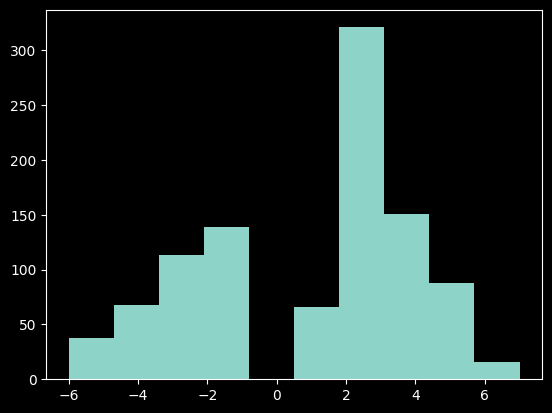

In [26]:
assert backup
stats = [run_game(backup) for _ in range(1000)]

plt.hist(stats)
sum(x > 0 for x in stats), len(stats)

In [24]:
torch.save(policy_net.state_dict(), "~dqn83 90 50 20 1.pth")

In [41]:
target_net.load_state_dict(torch.load("dqn.pth"))

C:\Users\mario\AppData\Local\Temp\ipykernel_268456\1728794949.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  target_net.load_state_dict(torch.load("dqn.pth"))


<All keys matched successfully>